
<h1>Analyzing a Movie Review Dataset</h1>

<h1>1. Processing text to create design matrices </h1>

<h3>Collecting parsed reviews</h3>

In [1]:
import pandas as pd 
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import nltk
#nltk.download(['stopwords'])
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np

train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

def parser(review):
    text_html = BeautifulSoup(review,"html.parser").get_text()
    letters_only = re.sub("[^a-zA-Z]"," ",text_html)  
    words = letters_only.lower().split()
    stopsets = set(stopwords.words("english"))
    words_without_stopwords = [w for w in words if not w in stopsets]
    review_parsed = " ".join(words_without_stopwords)
    return review_parsed

review_parsed = []
for i in range(train["review"].size):
    review_parsed.append(parser(train["review"][i]))


<h3>Creating X_counts</h3>

In [2]:
vectorizer = CountVectorizer(analyzer = "word",max_features = 5000) 
X_counts = vectorizer.fit_transform(review_parsed)
X_counts = X_counts.toarray()

<h3>Creating X_binary</h3>

In [3]:
X_binary = np.where(X_counts<1,X_counts,1)

<h3>Creating X_tfidf</h3>

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = transformer.fit_transform(X_counts)
X_tfidf = X_tfidf.toarray()

<h3>Creating X_binary_imbalance</h3>

In [18]:
tot_amount = len(train["sentiment"])
amount_1 = train[train["sentiment"]==1].index
np.random.seed(0)
remove_indices = np.random.choice(amount_1, int(0.75 * len(amount_1)), replace = False)
keep_indices = [i for i in range(0,tot_amount) if i not in remove_indices]
X_binary_imbalance = X_binary[keep_indices,:]
train_imbalance = train.ix[keep_indices]

<h3>Creating class variable</h3>

In [6]:
Y = train["sentiment"]
Y_imbalance = Y[keep_indices]

<h1>2. Feature space similarity experiment</h1>

<h3>Creating dist function</h3>

In [7]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import squareform
import time

def dist(X, i, j, distance_function):
    return cdist(X[i].reshape((1,5000)),X[j].reshape((1,5000)), distance_function.lower())
    

<h3>Creating topK function</h3>

In [8]:
def topK(X,k):
    start = time.time()
    distances = euclidean_distances(X, X)
    upperonly = np.triu_indices(distances.shape[0],1)
    flat = distances[upperonly] 
    flat[flat==0] = np.inf
    leastk = np.argpartition(flat,k)[:k]
    tri = np.stack((np.triu_indices(distances.shape[0], 1)[0], np.triu_indices(distances.shape[0], 1)[1]), axis=-1)
    X_tuple = []
    for i,j in tri[leastk]:
        X_tuple.append((i,j,distances[i][j]))
    end = time.time()
    timelapse = (end - start)/60
    print('Time taken to run %0.2f minutes' % timelapse)
    return X_tuple

 <h3>TopK (k=10) reviews for X_counts</h3>

In [9]:
X_counts_dist = topK(X_counts,10)
kTop = sorted(X_counts_dist, key=lambda x: x[2])
for i,j,d in kTop:
    print (i,review_parsed[i][:20],j,review_parsed[j][:20],d,Y[i],Y[j])

Time taken to run 3.01 minutes
2052 atlantis much better 20915 atlantis much better 1.0 1 1
11876 big fan rom coms bes 21854 big fan rom coms bes 1.0 0 0
7663 saw theater fell cha 11331 saw theater fell cha 1.0 1 1
17927 liked stanley iris m 23442 liked stanley iris m 1.0 1 1
7245 really surprised mov 16635 really suprised movi 1.0 1 1
7758 kurt russell best ma 18697 kurt russell best ma 1.0 1 1
5930 movie beautiful scen 8651 movie beautiful scen 1.41421356237 0 0
3217 brothers psychokinet 13530 brothers psychokinet 1.41421356237 1 1
14007 full length feature  15296 full length feature  1.41421356237 1 1
17096 college dorm guy kil 21325 college dorm guy kil 1.73205080757 0 0


<h3>TopK (k=10) reviews for X_binary</h3>

In [10]:
X_binary_dist = topK(X_binary,10)
kTop = sorted(X_binary_dist, key=lambda x: x[2])
for i,j,d in kTop:
    print (i,review_parsed[i][:20],j,review_parsed[j][:20],d,Y[i],Y[j])

Time taken to run 2.97 minutes
2052 atlantis much better 20915 atlantis much better 1.0 1 1
7758 kurt russell best ma 18697 kurt russell best ma 1.0 1 1
17927 liked stanley iris m 23442 liked stanley iris m 1.0 1 1
3217 brothers psychokinet 13530 brothers psychokinet 1.0 1 1
5930 movie beautiful scen 8651 movie beautiful scen 1.0 0 0
11876 big fan rom coms bes 21854 big fan rom coms bes 1.0 0 0
7663 saw theater fell cha 11331 saw theater fell cha 1.0 1 1
7245 really surprised mov 16635 really suprised movi 1.0 1 1
14007 full length feature  15296 full length feature  1.41421356237 1 1
6864 praised atlantis los 14534 praised atlantis los 1.41421356237 0 0


<h3>TopK (k=10) reviews for X_tfidf</h3>

In [11]:
X_tfidf_dist = topK(X_tfidf,10)
kTop = sorted(X_tfidf_dist, key=lambda x: x[2])
for i,j,d in kTop:
    print (i,review_parsed[i][:20],j,review_parsed[j][:20],d,Y[i],Y[j])

Time taken to run 2.97 minutes
2159 sat almost one episo 5283 sat almost one episo 1.49011611938e-08 0 0
2804 think almost need sa 4762 think almost need sa 1.49011611938e-08 0 0
4946 bfg one roald dahl c 18716 bfg one roald dahl c 1.49011611938e-08 0 0
612 reason see movie goo 10730 reason see movie goo 1.49011611938e-08 0 0
4937 longtime fan bette m 7794 longtime fan bette m 1.49011611938e-08 1 1
5651 used watch show litt 7034 used watch show litt 1.49011611938e-08 1 1
4294 time period exhausti 18778 time period exhausti 1.49011611938e-08 0 0
7248 movie disgrace major 7915 movie disgrace major 1.49011611938e-08 0 0
5656 goodnight mister tom 10451 goodnight mister tom 1.49011611938e-08 0 0
3140 really need narcissi 5970 really need narcissi 1.49011611938e-08 0 0


<h3>TopK (k=10) reviews for X_binary_imbalance</h3>

In [14]:
X_imbalance_dist = topK(X_binary_imbalance,10)
kTop = sorted(X_imbalance_dist, key=lambda x: x[2])
for i,j,d in kTop:
    i_t = train_imbalance.index.values[i]
    j_t = train_imbalance.index.values[j]
    print (i_t,review_parsed[i_t][:20],j_t,review_parsed[j_t][:20],d,Y[i_t],Y[j_t])

Time taken to run 0.89 minutes
5930 movie beautiful scen 8651 movie beautiful scen 1.0 0 0
11876 big fan rom coms bes 21854 big fan rom coms bes 1.0 0 0
6864 praised atlantis los 14534 praised atlantis los 1.41421356237 0 0
17096 college dorm guy kil 21325 college dorm guy kil 1.73205080757 0 0
20276 movie terrible good  22258 ming merciless littl 2.2360679775 0 0
12168 smallville episode j 22258 ming merciless littl 2.64575131106 1 0
3769 characters unlikeabl 22258 ming merciless littl 2.82842712475 0 0
22258 ming merciless littl 24222 rating begin express 2.82842712475 0 0
9038 comment movie imposs 20276 movie terrible good  2.82842712475 0 0
12168 smallville episode j 20276 movie terrible good  2.82842712475 1 0


<h1>3. Classification Experiment</h1>

In [29]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def best_classifier_roc_plot(X_t,Y_t):
    start = time.time()
    trainX, testX, trainY, testY = train_test_split(X_t, Y_t, test_size=0.2, random_state=0)
    s = np.random.uniform(0.0001,10000,30)
    #s = np.logspace(0.0001,10000,30)
    worst_c = s[0]
    best_c = s[0]
    max_auc = 0
    min_auc = 1
    for c in s:
        lin_svm = LinearSVC(C=c) 
        scores = cross_val_score(lin_svm, trainX, trainY, scoring='roc_auc',cv=5)  ##scoring='roc_auc'
        cur_auc = np.mean(scores)  ## Cross validation score
        print 
        if cur_auc > max_auc :
            max_auc = cur_auc
            best_c = c
        if cur_auc < min_auc :
            min_auc = cur_auc
            worst_c = c
            
    ##AUC Lift
    lift = ((max_auc - min_auc) / min_auc)*100


    ## Train the model with best C value
    lin_svm_retrain = LinearSVC(C=best_c) 
    lin_svm_retrain_calib = CalibratedClassifierCV(lin_svm_retrain) 
    svm_model = lin_svm_retrain_calib.fit(trainX, trainY)  
    testY_pred = svm_model.predict(testX)
    probs = svm_model.predict_proba(testX)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(testY, preds)
    roc_auc = metrics.auc(fpr, tpr)

    #Plot ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    end = time.time()
    timelapse = (end - start)/60
    print('AUC Lift is %0.2f %%' % lift)
    print('Time taken to run %0.2f minutes' % timelapse) 

    return best_c

def kaggle_counts(best_c_counts):
    
    kaggletest = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)
    review_parsed_k = []
    for i in range(kaggletest["review"].size):
        review_parsed_k.append(parser(kaggletest["review"][i]))

    X_counts_k = vectorizer.transform(review_parsed_k).toarray()    
    Y_counts_k = LinearSVC(C = best_c_counts).fit(X_counts, Y).predict(X_counts_k)
    
    output = pd.DataFrame( data={"id":kaggletest["id"], "sentiment":Y_counts_k} )
    output.to_csv( "Counts_k.csv", index=False, quoting=3 )
    
    return X_counts_k,kaggletest
    
def kaggle_binary(best_c_binary,X_counts_k,kaggletest):
    
    X_binary_k = np.where(X_counts_k<1,X_counts_k,1) 
    Y_binary_k = LinearSVC(C = best_c_binary).fit(X_binary, Y).predict(X_binary_k)
    
    output = pd.DataFrame( data={"id":kaggletest["id"], "sentiment":Y_binary_k} )
    output.to_csv( "Binary_k.csv", index=False, quoting=3 )
    
    return X_binary_k
    
def kaggle_tfidf(best_c_tfidf,X_counts_k,kaggletest):
        
    X_tfidf_k = transformer.transform(X_counts_k).toarray()
    Y_tfidf_k = LinearSVC(C = best_c_tfidf).fit(X_tfidf, Y).predict(X_tfidf_k)
    
    output = pd.DataFrame( data={"id":kaggletest["id"], "sentiment":Y_tfidf_k} )
    output.to_csv( "Tfidf_k.csv", index=False, quoting=3 )

def kaggle_imbalance(best_c_imbalance,X_binary_k,kaggletest):
    
    Y_binary_imbalance_k = LinearSVC(C = best_c_imbalance).fit(X_binary_imbalance, Y_imbalance).predict(X_binary_k)
    
    output = pd.DataFrame( data={"id":kaggletest["id"], "sentiment":Y_binary_imbalance_k} )
    output.to_csv( "Imbalance_k.csv", index=False, quoting=3 )
    
    

<h2>ROC for X_counts</h2>

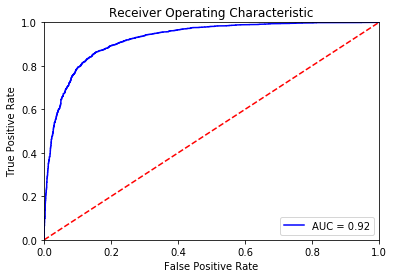

AUC Lift is 0.03 %
Time taken to run 7.81 minutes


In [30]:
import time
best_c_counts = best_classifier_roc_plot(X_counts,Y)
#Calling function to create kaggle csv
X_counts_k,kaggletest = kaggle_counts(best_c_counts)

<h4>Kagge Score : 0.80372</h4>

<h2>ROC for X_binary</h2>

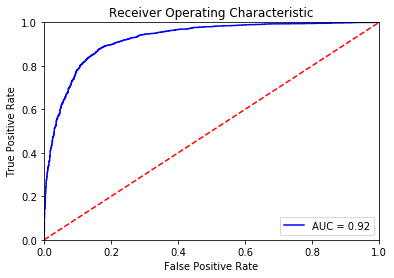

AUC Lift is 0.13 %
Time taken to run 7.03 minutes


In [15]:
best_c_binary = best_classifier_roc_plot(X_binary,Y)
X_binary_k = kaggle_binary(best_c_binary,X_counts_k,kaggletest)

<h4>Kaggle Score : 0.81576</h4>

<h2>ROC for X_tfidf</h2>

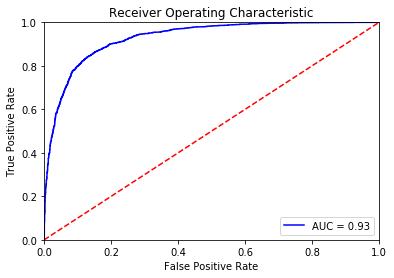

AUC Lift is 0.19 %
Time taken to run 6.46 minutes


In [31]:
best_c_tfidf = best_classifier_roc_plot(X_tfidf,Y)
kaggle_tfidf(best_c_tfidf,X_counts_k,kaggletest)

<h4>Kaggle Score : 0.80672</h4>

<h2>ROC for X_binary_imbalance</h2>

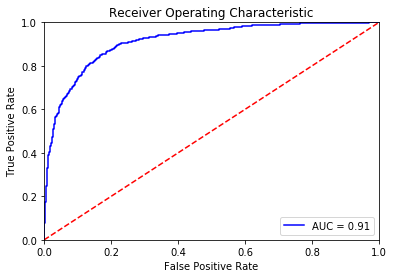

AUC Lift is 0.00 %
Time taken to run 2.34 minutes


In [13]:
best_c_imbalance = best_classifier_roc_plot(X_binary_imbalance,Y_imbalance)
kaggle_imbalance(best_c_imbalance,X_binary_k,kaggletest)

<h4>Kaggle Score : 0.78340</h4>
<h4>Interpretation</h4>
Of all the 4 design matrices, TFIDF performed the best with area under the curve of 0.93. This is because TFIDF allows the 5000 words to have a weightage with respect to each document (review in our case) . This information is more valuable than just the counts of the words in the review or the merry fact that it is present or not (as in the case of binary).

<h1>4. Learning Curve Experiment</h1>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc = 'lower right')
    return plt

def logistic_learning_curve(X_t,Y_t,scoring):
    title = "Learning Curves (Logistic Regression)"
    logistic = LogisticRegression(random_state=0)
    train_sizes= np.array([100, 500, 1000, 2000,3000, 4000, 5000, 7500, 10000, 15000, 20000])
    plot_learning_curve(logistic, title, X_t, Y_t, ylim=(0.3, 1.01), cv=5, n_jobs=1,train_sizes=train_sizes,scoring=scoring)
    plt.show()


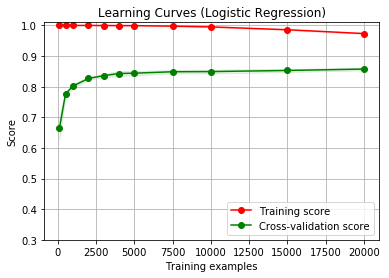

In [38]:
logistic_learning_curve(X_counts,Y,'accuracy')

<h4>Interpretation</h4>
As we decrease the number of train samples we can see the training accuracy is close to 1 and the testing accuracy is decreasing. This shows that it is overfitting at lower train samples. 
<h4>Note :</h4>The above graph shows accuracy. The error is nothing but 1 - accuracy. The graph will be analogous and is shown below.

<h3>Learning curve with error</h3>

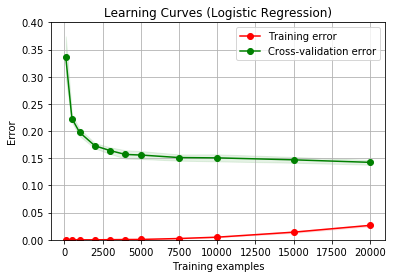

In [48]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = 1 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")
    plt.legend(loc = 'upper right')
    return plt

def logistic_learning_curve(X_t,Y_t,scoring):
    title = "Learning Curves (Logistic Regression)"
    logistic = LogisticRegression(random_state=0)
    train_sizes= np.array([100, 500, 1000, 2000,3000, 4000, 5000, 7500, 10000, 15000, 20000])
    plot_learning_curve(logistic, title, X_t, Y_t, ylim=(0, 0.4), cv=5, n_jobs=1,train_sizes=train_sizes,scoring=scoring)
    plt.show()

logistic_learning_curve(X_counts,Y,'accuracy')
